# TS-Similarity, Clustering
**OBJECTIVE** 
- Ways to calculate Similarity
    1. STUMPY (https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Euclidean-Distance-/yo%CD%9Eo%CB%88klid%C4%93%C9%99n/-/%CB%88dist%C9%99ns/-noun)
    2. DTAIDistance (https://github.com/wannesm/dtaidistance)
    3. Clustering using global TS features such as the following (some of which can be extracted using `tsfresh`)
        - trend
        - seasonality
        - periodicity
        - serial correlation
        - skewness
        - kurtosis
        - chaos
        - non-linearity
        - self-similarity
    4. Kriging (https://pypi.org/project/PyKrige/) using spacial coordinates such as Latitude & Longitude
        


### Imputation FIndings
- The imputation techniques are miserable as shown by R2 scores that make no sense
- Notably from the line graphs shown, the classic naive imputation technique of FillMean and / FillMed or Interpolate Time are the best for use at this time (**as a placeholder**) until another imputation technique is explored at a later time

In [1]:
import pandas as pd 
import numpy as np
import json
import tqdm

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from pprint import pprint
from sklearn.metrics import r2_score
from datetime import datetime

import zipcodes

import matplotlib.pyplot as plt
import seaborn as sns

# Append the entire repo parent director so files therein can be accessed in notebook
import os
import sys
import pathlib
sys.path.append(str(pathlib.Path().absolute().parent))

from src import helper
%load_ext autoreload

### Import Data

In [2]:
ca_zips = pd.read_pickle('../data/interim/ca-zip-w-city-ts.pickle')

In [3]:
interpol_0 = pd.read_pickle('../data/interim/interpolated_fillna0_df.pickle')
interpol_time = pd.read_pickle('../data/interim/interpolated_fillnaTime_df.pickle')

In [4]:
ca_zips.head(3)

,Date,ZipCode,City,County,Lat,Long,ZHVI_1bedroom,ZHVI_2bedroom,ZHVI_3bedroom,ZHVI_4bedroom,...,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,FIPS,MetroName,Unique_City_ID,State,ds
0,1996-04-30,90001,Los Angeles,Los Angeles,33.9736,-118.2479,94000.0,107300.0,121600.0,129200.0,...,128400.0,NaN,NaN,NaN,NaN,6037.0,"Los Angeles-Long Beach-Anaheim, CA",los_angeleslos_angelesca,CA,1996-04-30
1,1996-04-30,90002,Los Angeles,Los Angeles,33.9490,-118.2460,NaN,92700.0,111900.0,115600.0,...,121300.0,NaN,NaN,NaN,NaN,6037.0,"Los Angeles-Long Beach-Anaheim, CA",los_angeleslos_angelesca,CA,1996-04-30
2,1996-04-30,90003,Los Angeles,Los Angeles,33.9640,-118.2737,77800.0,90300.0,116400.0,NaN,...,124000.0,NaN,NaN,NaN,NaN,6037.0,"Los Angeles-Long Beach-Anaheim, CA",los_angeleslos_angelesca,CA,1996-04-30


In [5]:
ca_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332663 entries, 0 to 332662
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Date                             332663 non-null  object        
 1   ZipCode                          332663 non-null  object        
 2   City                             332663 non-null  object        
 3   County                           332663 non-null  object        
 4   Lat                              332663 non-null  object        
 5   Long                             332663 non-null  object        
 6   ZHVI_1bedroom                    78578 non-null   float64       
 7   ZHVI_2bedroom                    238484 non-null  float64       
 8   ZHVI_3bedroom                    295858 non-null  float64       
 9   ZHVI_4bedroom                    268698 non-null  float64       
 10  ZHVI_5BedroomOrMore              205647 non-

In [7]:
all_zips = list(set(ca_zips['ZipCode']))
len(all_zips)

1311

In [8]:
# Count how many zip codes have no rental information

no_rental_zips = set()
for zipcode in all_zips:
    sub_df = ca_zips[ca_zips['ZipCode'] == zipcode]
    if sub_df['Zri_MultiFamilyResidenceRental'].isnull().sum() == len(sub_df):
        no_rental_zips.add(zipcode)
    else:
        pass
    
len(no_rental_zips)

322

In [11]:
np.random.choice(list(no_rental_zips), 5)

array(['92253', '92285', '93646', '94511', '92676'], dtype='<U5')

### Create test dataframe using a test zipcode

In [6]:
test_zip = '90210'

In [7]:
test_ts = ca_zips[ca_zips['ZipCode'] == test_zip]
test_ts.reset_index(drop=True, inplace=True)
test_ts.shape

(261, 26)

In [8]:
# I know BH properties are CRAZY expensive, so this is just to sanity check that ZHVI and ZRI are aligned
# w/ recent market prices in the last few years

test_ts[test_ts['Date'].str.contains('2017')].head(3)

,Date,ZipCode,City,County,Lat,Long,ZHVI_1bedroom,ZHVI_2bedroom,ZHVI_3bedroom,ZHVI_4bedroom,...,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,FIPS,MetroName,Unique_City_ID,State,ds
249,2017-01-31,90210,Beverly Hills,Los Angeles,34.1031,-118.4163,891400.0,1459700.0,2837600.0,5331200.0,...,9887500.0,17636.0,16132.0,4398.0,19872.0,6037.0,"Los Angeles-Long Beach-Anaheim, CA",beverly_hillslos_angelesca,CA,2017-01-31
250,2017-02-28,90210,Beverly Hills,Los Angeles,34.1031,-118.4163,895400.0,1453100.0,2829800.0,5358100.0,...,9962700.0,17368.0,15954.0,4395.0,19732.0,6037.0,"Los Angeles-Long Beach-Anaheim, CA",beverly_hillslos_angelesca,CA,2017-02-28
251,2017-03-31,90210,Beverly Hills,Los Angeles,34.1031,-118.4163,892900.0,1459500.0,2822200.0,5385200.0,...,10072500.0,17182.0,15879.0,4396.0,19600.0,6037.0,"Los Angeles-Long Beach-Anaheim, CA",beverly_hillslos_angelesca,CA,2017-03-31


In [9]:
zhvi_cols = [col for col in ca_zips.columns if 'zhvi' in col.lower()]
zri_cols = [col for col in ca_zips.columns if 'zri' in col.lower()]

pprint(zhvi_cols)
pprint(zri_cols)

['ZHVI_1bedroom',
 'ZHVI_2bedroom',
 'ZHVI_3bedroom',
 'ZHVI_4bedroom',
 'ZHVI_5BedroomOrMore',
 'ZHVI_AllHomes',
 'ZHVI_BottomTier',
 'ZHVI_CondoCoop',
 'ZHVI_MiddleTier',
 'ZHVI_SingleFamilyResidence',
 'ZHVI_TopTier']
['ZRI_AllHomes',
 'ZRI_AllHomesPlusMultifamily',
 'Zri_MultiFamilyResidenceRental',
 'Zri_SingleFamilyResidenceRental']


### Ways to Find Time Series Similarity
1. STUMPY (https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Euclidean-Distance-/yo%CD%9Eo%CB%88klid%C4%93%C9%99n/-/%CB%88dist%C9%99ns/-noun)
2. DTAIDistance (https://github.com/wannesm/dtaidistance)
3. Clustering using global TS features such as the following (some of which can be extracted using `tsfresh`)
    - trend
    - seasonality
    - periodicity
    - serial correlation
    - skewness
    - kurtosis
    - chaos
    - non-linearity
    - self-similarity


#### DTAIDistance
- Convert the time series for each of the zipcodes into np.arrays
- Need to select a particular column upon which to perform this exercise: `Zri_MultiFamilyResidenceRental`

In [18]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import clustering

In [19]:
# To convert the series to numpy arrays for each zip code, we need to
# Make an assumption on how to impute the null values before heirarchical clustering can be used

zip_ts_0_zhvi_arrays = dict()
zip_ts_0_zri_arrays = dict()

zip_ts_inter_zhvi_arrays = dict()
zip_ts_inter_zri_arrays = dict()

for zipcode in all_zips:
    try:
        sub0_df = interpol_0[interpol_0['ZipCode'] == zipcode]
        subInter = interpol_time[interpol_time['ZipCode'] == zipcode]
        
        sub0_df.reset_index(drop=True, inplace=True)
        subInter.reset_index(drop=True, inplace=True)
        
        zip_ts_0_zhvi_arrays[zipcode] = np.array(sub0_df['ZHVI_SingleFamilyResidence'], dtype=np.double)
        zip_ts_0_zri_arrays[zipcode] = np.array(sub0_df['Zri_MultiFamilyResidenceRental'], dtype=np.double)
        
        zip_ts_inter_zhvi_arrays[zipcode] = np.array(subInter['ZHVI_ITime'], dtype=np.double)
        zip_ts_inter_zri_arrays[zipcode] = np.array(subInter['ZRI_ITime'], dtype=np.double)
        
    except:
        pass
    
print(len(zip_ts_0_zhvi_arrays))
print(len(zip_ts_0_zri_arrays))

print(len(zip_ts_inter_zhvi_arrays))
print(len(zip_ts_inter_zri_arrays))

1311
1311
1311
1311


In [20]:
# Do pairwise distances and calculate those for each of the zipcode combinations
# Then for each zipcode we want the smallest distance forb the subject zipcode and the most similar
# Spot check w/ visualizations
# Perform heirarchical clustering

In [21]:
np.random.choice(sorted(zip_ts_0_zhvi_arrays), 2)

array(['94503', '95128'], dtype='<U5')

In [22]:
test_distance = dtw.distance(zip_ts_0_zhvi_arrays['94127'], zip_ts_0_zhvi_arrays['90016'])
test_path = path = dtw.warping_path(zip_ts_0_zhvi_arrays['94127'], zip_ts_0_zhvi_arrays['90016'])
dtwvis.plot_warping(zip_ts_0_zhvi_arrays['94127'], zip_ts_0_zhvi_arrays['90016'], path, filename="warp.png")

(None, None)

In [23]:
test_zip

'90210'

In [24]:
from tqdm import tqdm_notebook

In [25]:
non_test_zips = [zipcode for zipcode in all_zips if zipcode != test_zip]

%time
seen_pairs = dict()

for zipcode in tqdm_notebook(non_test_zips):
    if (zipcode, test_zip) not in seen_pairs or (test_zip, zipcode) not in seen_pairs:
        dist = dtw.distance(zip_ts_0_zhvi_arrays[zipcode], zip_ts_0_zhvi_arrays[test_zip])
        seen_pairs[(test_zip, zipcode)] = dist

In [26]:
min(seen_pairs.values())

5463650.089454851

In [27]:
[k for k,v in seen_pairs.items() if v == min(seen_pairs.values())]

[('90210', '94027')]

In [28]:
path = dtw.warping_path(zip_ts_0_zhvi_arrays['90210'], zip_ts_0_zhvi_arrays['94027'])
dtwvis.plot_warping(zip_ts_0_zhvi_arrays['90210'], zip_ts_0_zhvi_arrays['94027'], path, filename="warp.png")

(None, None)

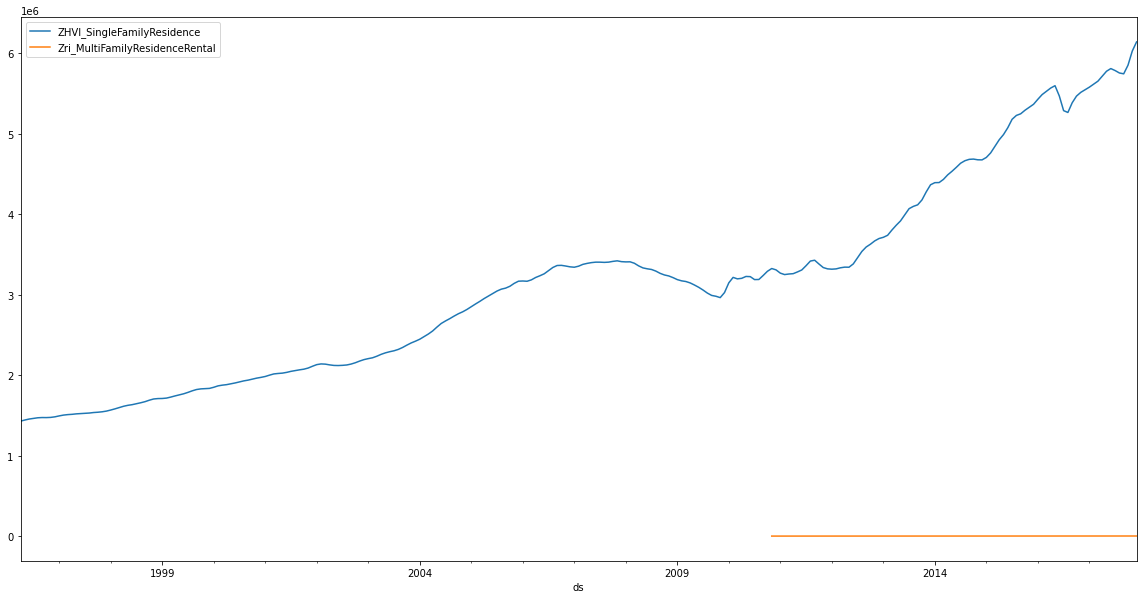

In [29]:
nine0210 = ca_zips[(ca_zips['ZipCode'] == '90210')]
nine0210.set_index('ds', inplace=True)
nine0210[['ZHVI_SingleFamilyResidence', 'Zri_MultiFamilyResidenceRental']].plot(figsize=(20, 10))

In [30]:
nine0210[nine0210['Date'].str.contains('2017')].head()

,Date,ZipCode,City,County,Lat,Long,ZHVI_1bedroom,ZHVI_2bedroom,ZHVI_3bedroom,ZHVI_4bedroom,...,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,FIPS,MetroName,Unique_City_ID,State
ds,,,,,,,,,,,,,,,,,,,,,
2017-01-31,2017-01-31,90210,Beverly Hills,Los Angeles,34.1031,-118.4163,891400.0,1459700.0,2837600.0,5331200.0,...,5580000.0,9887500.0,17636.0,16132.0,4398.0,19872.0,6037.0,"Los Angeles-Long Beach-Anaheim, CA",beverly_hillslos_angelesca,CA
2017-02-28,2017-02-28,90210,Beverly Hills,Los Angeles,34.1031,-118.4163,895400.0,1453100.0,2829800.0,5358100.0,...,5617000.0,9962700.0,17368.0,15954.0,4395.0,19732.0,6037.0,"Los Angeles-Long Beach-Anaheim, CA",beverly_hillslos_angelesca,CA
2017-03-31,2017-03-31,90210,Beverly Hills,Los Angeles,34.1031,-118.4163,892900.0,1459500.0,2822200.0,5385200.0,...,5654600.0,10072500.0,17182.0,15879.0,4396.0,19600.0,6037.0,"Los Angeles-Long Beach-Anaheim, CA",beverly_hillslos_angelesca,CA
2017-04-30,2017-04-30,90210,Beverly Hills,Los Angeles,34.1031,-118.4163,895800.0,1473000.0,2834100.0,5424200.0,...,5716900.0,10189000.0,17015.0,15803.0,4392.0,19447.0,6037.0,"Los Angeles-Long Beach-Anaheim, CA",beverly_hillslos_angelesca,CA
2017-05-31,2017-05-31,90210,Beverly Hills,Los Angeles,34.1031,-118.4163,909600.0,1517900.0,2844200.0,5457800.0,...,5777700.0,10288300.0,16912.0,15736.0,4417.0,19299.0,6037.0,"Los Angeles-Long Beach-Anaheim, CA",beverly_hillslos_angelesca,CA


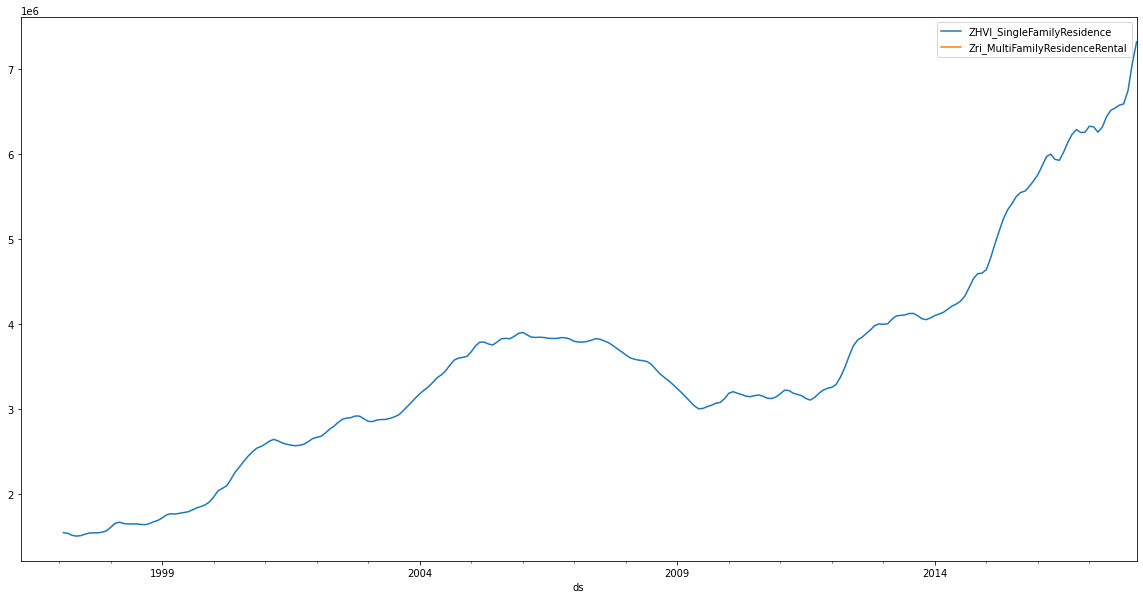

In [31]:
nine4027 = ca_zips[(ca_zips['ZipCode'] == '94027')]
nine4027.set_index('ds', inplace=True)
nine4027[['ZHVI_SingleFamilyResidence', 'Zri_MultiFamilyResidenceRental']].plot(figsize=(20, 10))

In [32]:
nine4027[nine4027['Date'].str.contains('2017')].head()

,Date,ZipCode,City,County,Lat,Long,ZHVI_1bedroom,ZHVI_2bedroom,ZHVI_3bedroom,ZHVI_4bedroom,...,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,FIPS,MetroName,Unique_City_ID,State
ds,,,,,,,,,,,,,,,,,,,,,
2017-01-31,2017-01-31,94027,Atherton,San Mateo,37.4501,-122.2050,NaN,3208300.0,4848700.0,5724000.0,...,6322200.0,10963200.0,17083.0,16569.0,NaN,16835.0,6081.0,"San Francisco, CA",athertonsan_mateoca,CA
2017-02-28,2017-02-28,94027,Atherton,San Mateo,37.4501,-122.2050,NaN,3110000.0,4858900.0,5772100.0,...,6314500.0,10962500.0,17052.0,16513.0,NaN,16767.0,6081.0,"San Francisco, CA",athertonsan_mateoca,CA
2017-03-31,2017-03-31,94027,Atherton,San Mateo,37.4501,-122.2050,NaN,3070700.0,4882700.0,5787000.0,...,6251900.0,10950200.0,17015.0,16508.0,NaN,16761.0,6081.0,"San Francisco, CA",athertonsan_mateoca,CA
2017-04-30,2017-04-30,94027,Atherton,San Mateo,37.4501,-122.2050,NaN,3048400.0,4955800.0,5850000.0,...,6309700.0,11017900.0,17039.0,16569.0,NaN,16831.0,6081.0,"San Francisco, CA",athertonsan_mateoca,CA
2017-05-31,2017-05-31,94027,Atherton,San Mateo,37.4501,-122.2050,NaN,3032400.0,5016800.0,5945700.0,...,6433300.0,11105900.0,17075.0,16666.0,NaN,16914.0,6081.0,"San Francisco, CA",athertonsan_mateoca,CA


In [ ]:
%time
dist_ts_0_zhvi_arrays = dtw.distance_matrix_fast(list(zip_ts_0_zhvi_arrays.values()))
dist_ts_0_zri_arrays = dtw.distance_matrix_fast(list(zip_ts_0_zri_arrays.values()))

dist_ts_inter_zhvi_arrays = dtw.distance_matrix_fast(list(zip_ts_inter_zhvi_arrays.values()))
dist_ts_inter_zri_arrays = dtw.distance_matrix_fast(list(zip_ts_inter_zri_arrays.values()))

In [ ]:
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})

model2 = clustering.HierarchicalTree(model1)
cluster_idx = model2.fit(list(zip_ts_0_zhvi_arrays.values()))

In [ ]:
fig = plt.figure(figsize=(40, 10))
_ = model2.plot()
plt.show()

In [ ]:
from itertools import permutations

len(set(permutations(ca_zips['ZipCode'], 2)))